<a href="https://colab.research.google.com/github/SMSinclair/DS-Unit-2-Regression-1/blob/master/Stephen_Sinclair_evaluating_forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# importing Prophet deregisters the Pandas plotting matplotlib converters.
# reverse this by manually re-registering them.

pd.plotting.register_matplotlib_converters()

In [0]:
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [0]:
# read data from csv
# time series of wikipedia page views for "Socialism" by day

url = 'https://raw.githubusercontent.com/SMSinclair/csv_files/master/pageviews-20150717-20190527.csv'
soc = (pd.read_csv(url, parse_dates=['Date'])
             .rename(columns={'Date':'ds', 'Socialism':'y'}))

## Train/test split

In [0]:
# set ds as index for use in slicing for train/test split

soc = soc.set_index('ds')

In [5]:
# do a train/test split

soc_train = soc[:'2018-09-17']
soc_train.tail()

,y
ds,
2018-09-13,5999
2018-09-14,5982
2018-09-15,5219
2018-09-16,5576
2018-09-17,6049


In [6]:
soc_test = soc['2018-09-18':]
soc_test.head()

,y
ds,
2018-09-18,5555
2018-09-19,5182
2018-09-20,5069
2018-09-21,4230
2018-09-22,3785


In [0]:
# reset the index, making ds a column again

soc_train = soc_train.reset_index()
soc_test = soc_test.reset_index()

In [8]:
soc_train.dtypes

ds    datetime64[ns]
y              int64
dtype: object

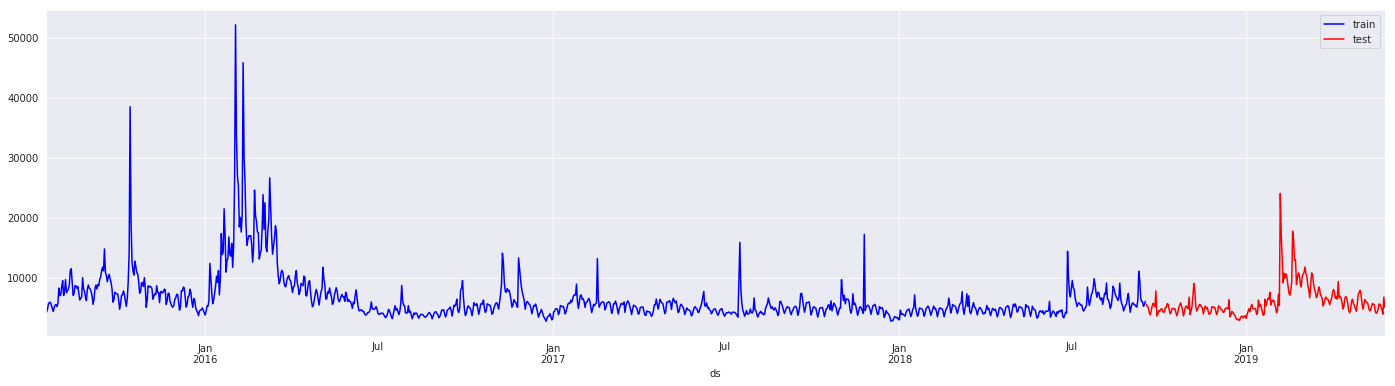

In [25]:
# plot time series with train/test split

sns.set_style('darkgrid')

ax = soc_train.plot(x='ds', y='y', color='blue', label='train', figsize=(24,6))
soc_test.plot(x='ds', y='y', color='red', label='test', ax=ax)

## Mean Baseline

In [21]:
# create mean_basline feature, print average daily page views 

soc_train['mean_baseline'] = soc_train['y'].mean()
soc_test['mean_baseline']  = soc_train['y'].mean()
print('Average daily page view, train: ' + str(soc_train['y'].mean()))

Average daily page view, train: 6442.980155306299


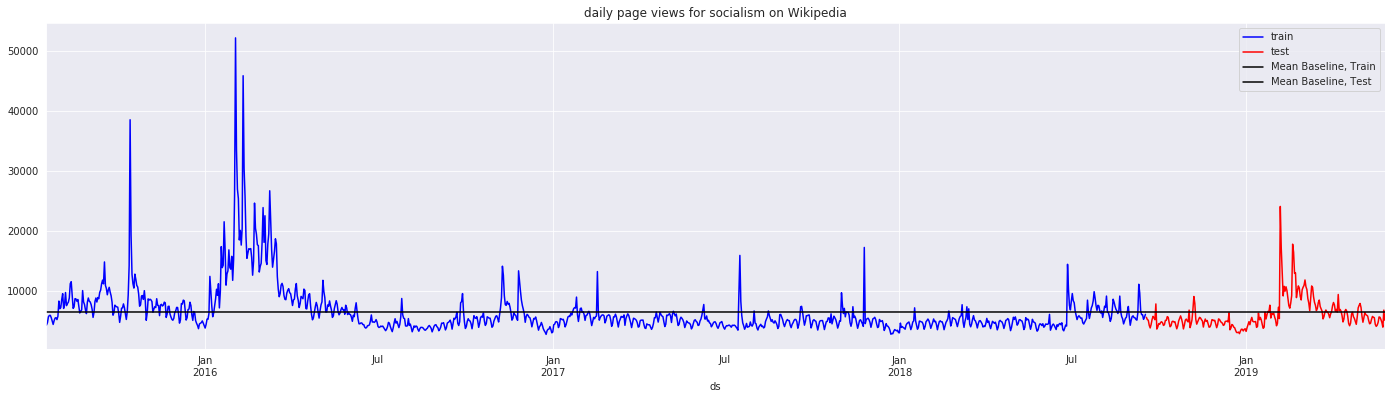

In [26]:
# plot train/test with mean baseline

ax = soc_train.plot(x='ds', y='y', color='blue', label='train', figsize=(24,6))
soc_test.plot(x='ds', y='y', color='red', label='test', ax=ax)
soc_train.plot(x='ds', y='mean_baseline', color='black', 
           label='Mean Baseline, Train', ax=ax)
soc_test.plot(x='ds', y='mean_baseline', color='black', 
          label='Mean Baseline, Test', ax=ax)
plt.title('daily page views for socialism on Wikipedia');

In [22]:
# calculate and print the mean absolute error for train/test

train_mae = mean_absolute_error(soc_train['y'], soc_train['mean_baseline'])
test_mae = mean_absolute_error(soc_test['y'], soc_test['mean_baseline'])
print('Train MAE, for mean baseline:', train_mae)
print('Test MAE, for mean baseline:', test_mae)

Train MAE, for mean baseline: 2345.814853332996
Test MAE, for mean baseline: 1887.6583192955065


## Naive baseline

In [0]:
# create naive baseline
# shift each observation one to the right, bfill to fill first np.nan value
# use final train observation to predict all future observations

soc_train['naive_baseline'] = soc_train['y'].shift(1).bfill()
soc_train_last_observation = soc_train['naive_baseline'].iloc[-1]
soc_test['naive_baseline'] = soc_train_last_observation

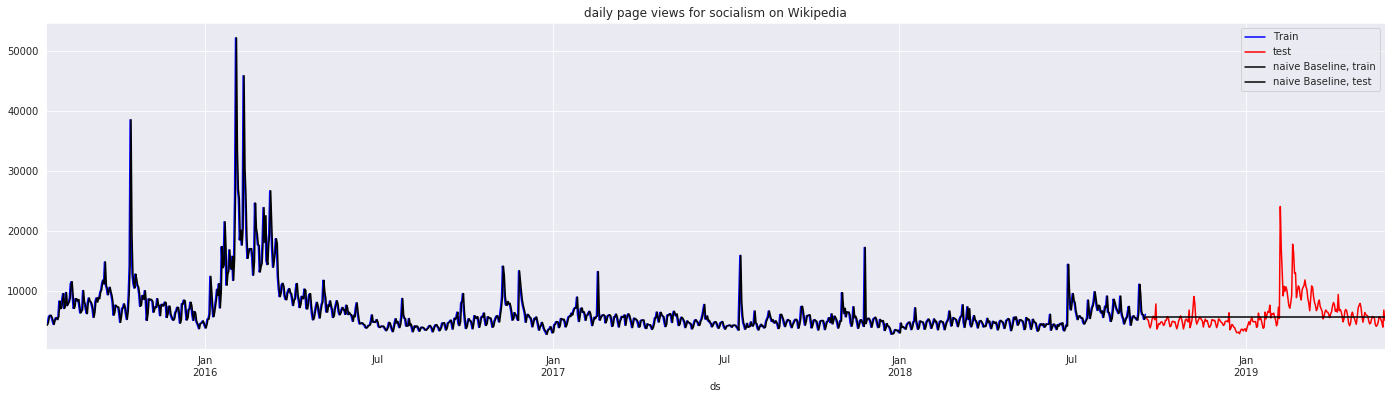

In [27]:
# plot train/test with naive baseline

ax = soc_train.plot(x='ds', y='y', color='blue', label='Train', figsize=(24,6))
soc_test.plot(x='ds', y='y', color='red', ax=ax, 
         label='test')
soc_train.plot(x='ds', y='naive_baseline', color='black', 
           label='naive Baseline, train', ax=ax)
soc_test.plot(x='ds', y='naive_baseline', color='black', 
           label='naive Baseline, test', ax=ax)
plt.title('daily page views for socialism on Wikipedia')
plt.show()

In [23]:
# get MAE for naive baseline
# it's fairly accurate

train_mae = mean_absolute_error(soc_train['y'], soc_train['naive_baseline'])
test_mae = mean_absolute_error(soc_test['y'], soc_test['naive_baseline'])
print('Train MAE, for mean baseline:', train_mae)
print('Test MAE, for mean baseline:', test_mae)

Train MAE, for mean baseline: 992.4236410698878
Test MAE, for mean baseline: 1628.920634920635


## Prophet forecast

In [28]:
# use Prophet to forecast time series

%%time
soc_model = Prophet(daily_seasonality=False)
soc_model.fit(soc_train)
train_forecast = soc_model.predict(soc_train)
test_forecast = soc_model.predict(soc_test)

CPU times: user 8.37 s, sys: 2.72 s, total: 11.1 s
Wall time: 7.75 s


In [0]:
train_forecast.tail()

In [0]:
test_forecast.head()

In [37]:
train_forecast.shape, test_forecast.shape

((1159, 19), (252, 19))

Text(0.5, 1.0, 'Daily Wikipedia page views for "Socialism"')

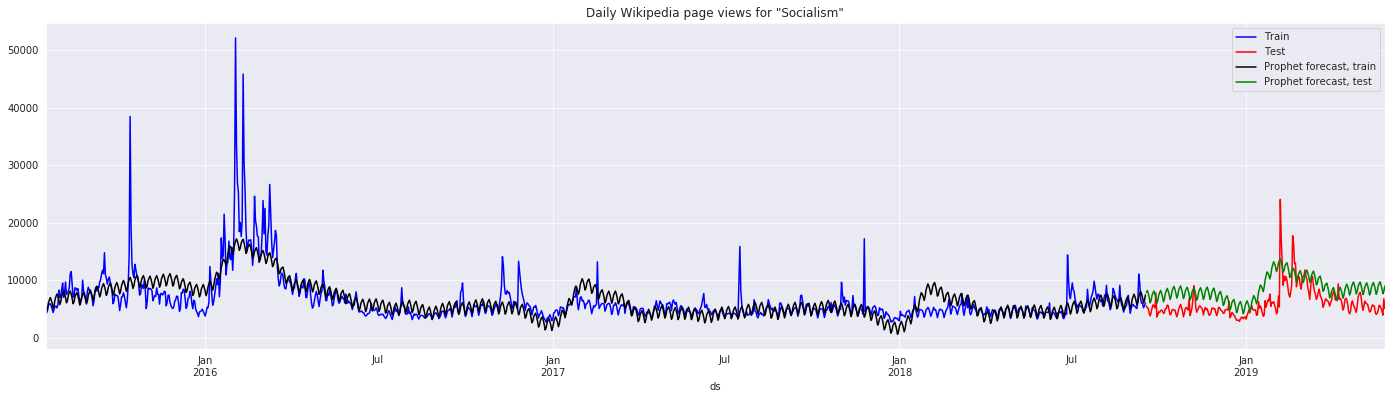

In [49]:
# plot train/test with Prophet forecasts

ax = soc_train.plot(x='ds', y='y', color='blue', label='Train', figsize=(24,6))
soc_test.plot(x='ds', y='y', color='red', label='Test', ax=ax)

train_forecast.plot(x='ds', y='yhat', color='black', 
                    label='Prophet forecast, train', ax = ax)
test_forecast.plot(x='ds', y='yhat', color='green', 
                    label='Prophet forecast, test', ax = ax)
plt.title('Daily Wikipedia page views for "Socialism"')

In [34]:
# naive baseline is actually better than Prophet with default parameters for the 
# train data. But naive baseline is terrible for predicting further out into the 
# future.

train_mae = mean_absolute_error(soc_train['y'], train_forecast['yhat'])
test_mae = mean_absolute_error(soc_test['y'], test_forecast['yhat'])
print('Train MAE for Prophet(default params):', train_mae)
print('Test MAE for Prophet(default params):', test_mae)

Train MAE for Prophet(default params): 1517.5660557843062
Test MAE for Prophet(default params): 2728.284071302096


## Do time series cross-validation using these Prophet functions


*   cross_validation
*   performance_metrics
*   plot_cross_validation_metric



In [35]:
# time series cross-validation using Prophet function

df_cv = cross_validation(soc_model, horizon = '120 days')

INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-07-29 00:00:00 and 2018-05-20 00:00:00


In [36]:
df_cv.shape

(1440, 6)

In [40]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-07-30,5194.852846,1382.012119,8842.667586,4127,2016-07-29
1,2016-07-31,6061.942328,2137.655610,10177.230160,4094,2016-07-29
2,2016-08-01,7623.291708,3921.015029,11428.291034,4150,2016-07-29
3,2016-08-02,8859.077249,4784.925964,12708.675526,5344,2016-07-29
4,2016-08-03,9878.843253,6341.114099,13797.656760,4199,2016-07-29


In [0]:
help(performance_metrics)

In [55]:
# performance metrics

performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,12 days,2.756831e+07,5250.552952,4052.383702,0.804433,0.611111
1,13 days,2.964397e+07,5444.627768,4190.881672,0.844437,0.590278
2,14 days,3.179511e+07,5638.715278,4351.125747,0.885711,0.569444
3,15 days,3.403335e+07,5833.810781,4526.487659,0.918596,0.541667
4,16 days,3.484556e+07,5903.013091,4598.518146,0.953961,0.527778
5,17 days,3.625713e+07,6021.389111,4715.694998,0.989635,0.513889
6,18 days,3.756340e+07,6128.898931,4829.336521,1.019901,0.493056
7,19 days,3.838215e+07,6195.332819,4913.640521,1.036219,0.472222
8,20 days,3.915642e+07,6257.509458,4971.583424,1.056106,0.451389
9,21 days,3.971686e+07,6302.131517,5011.415401,1.074149,0.451389


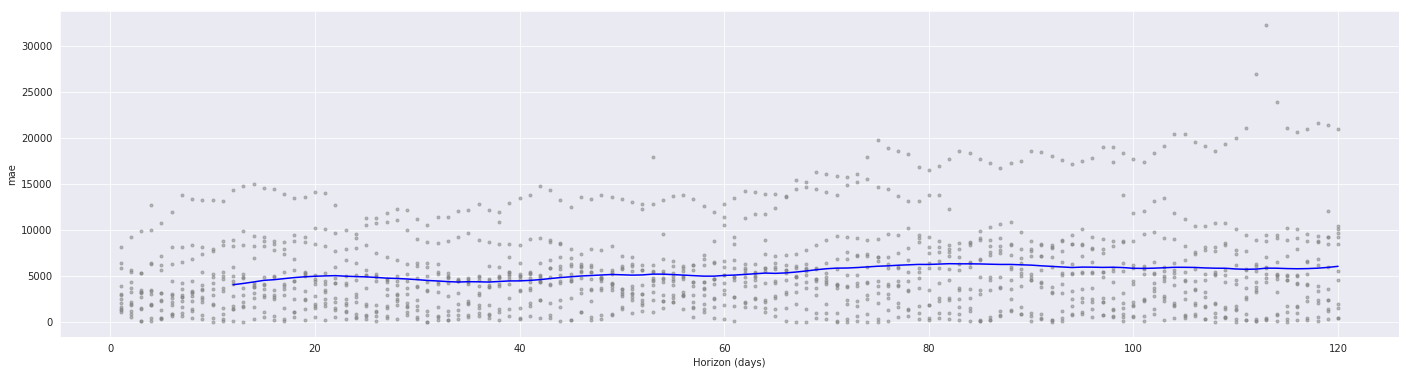

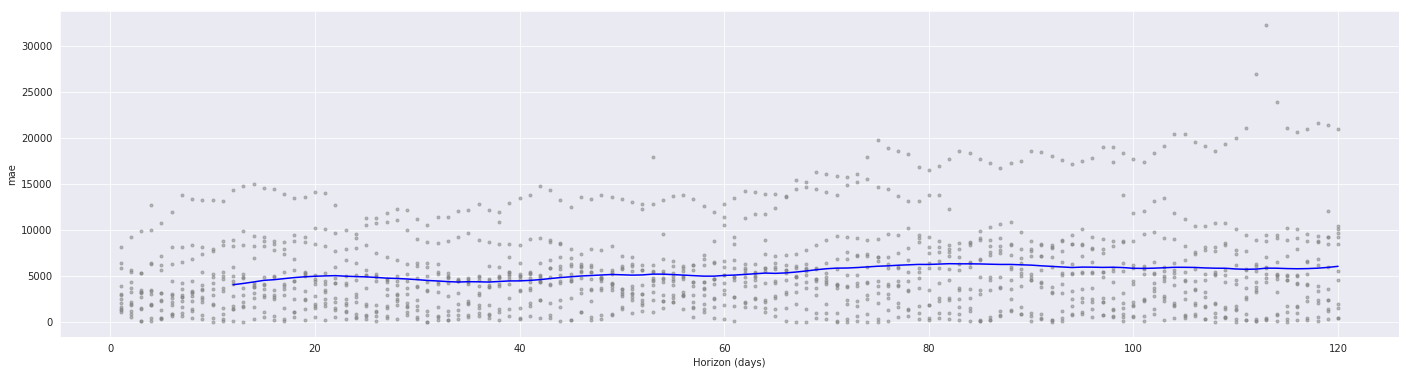

In [53]:
# plot cross-validation metric

plot_cross_validation_metric(df_cv, metric='mae', figsize=(24,6))

In [0]:
help(plot_cross_validation_metric)